**Clustering**

    1. Write down the expectation maximization (EM) steps for a simple 1D eample with two gaussians as shown in the lecture.

1. Start with random seeds
2. Calculate Expectation
3. Calculate new gaussians
4. Repeat untill convergence

I found https://medium.com/@prateek.shubham.94/expectation-maximization-algorithm-7a4d1b65ca55 helpful in implementing this.

    1.A) Draw a few samples from two gaussians of your choice

I'll draw 1000 samples from each of two gaussians that will serve as our truth

In [279]:
import numpy as np
from scipy.stats import norm
rng_state = 42

std_1 = 1.4
mean_1 = -0.5

std_2 = 1
mean_2 = 2

gaussian_1_truth = norm(scale = std_1, loc = mean_1)
gaussian_2_truth = norm(scale = std_2, loc = mean_2)



In [280]:
import pandas as pd
n_samples = 1000
sample_1 = pd.DataFrame(gaussian_1_truth.rvs(size = n_samples, random_state = rng_state), columns = ['samples']).sort_values('samples')
sample_2 = pd.DataFrame(gaussian_2_truth.rvs(size = n_samples, random_state = rng_state), columns = ['samples']).sort_values('samples')



Let's visualize the samples!

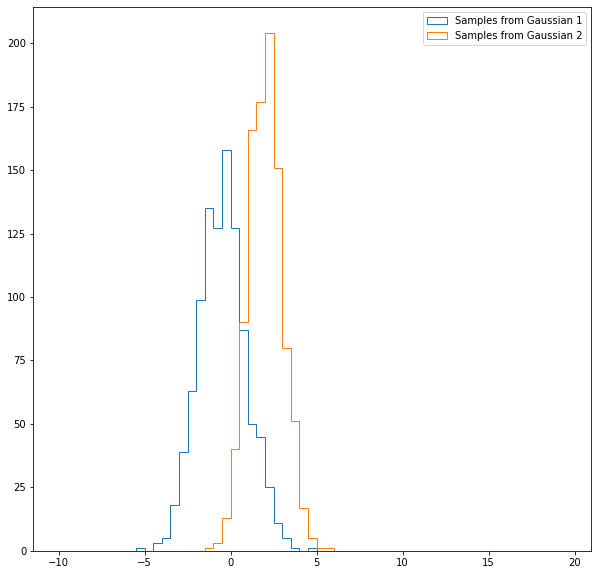

In [281]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
bins = np.arange(-10,20, 0.5)
plt.hist(sample_1['samples'], bins = bins, histtype = 'step', label = 'Samples from Gaussian 1')
plt.hist(sample_2['samples'], bins = bins, histtype = 'step', label = 'Samples from Gaussian 2')
plt.legend()

    1.B) What is the expectation of each point beloging to either of the two given gaussians?

Let's start be defining a function that calculates the expectation of "sample" being in "gaussian_1" given "gaussian_2" and a "prior".

In [282]:
def calculate_expectation(gaussian_1, gaussian_2, sample, prior):
    prob_1 = gaussian_1.pdf(sample['samples'])
    prob_2 = gaussian_2.pdf(sample['samples'])
    w1 = prior*prob_2
    w2 = (1-prior)*prob_1
    return w1/(w1+w2)

Let's now use this function to calculate the expectation of "sample_1" being in "sample_1", "sample_1" being in "sample_2", "sample_2" being in "sample_2", "sample_2" being in "sample_1".

In [283]:
sample_1['expectation_in_2'] = calculate_expectation(gaussian_1_truth, gaussian_2_truth, sample_1, prior = 0.1)
sample_1['expectation_in_1'] = calculate_expectation(gaussian_2_truth, gaussian_1_truth, sample_1, prior = 0.1)
sample_2['expectation_in_2'] = calculate_expectation(gaussian_1_truth, gaussian_2_truth, sample_2, prior = 0.1)
sample_2['expectation_in_1'] = calculate_expectation(gaussian_2_truth, gaussian_1_truth, sample_2, prior = 0.1)


Let's now visualize the results!

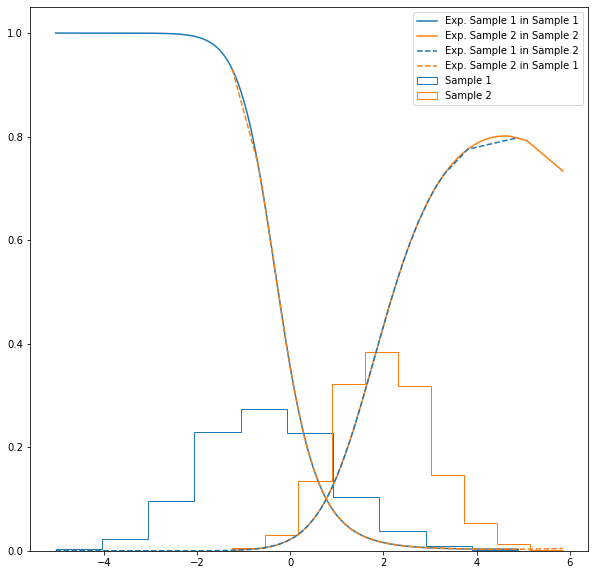

In [284]:
plt.figure(figsize = (10,10))
plt.plot(sample_1['samples'], sample_1['expectation_in_1'], label = 'Exp. Sample 1 in Sample 1', color = 'tab:blue')
plt.plot(sample_2['samples'], sample_2['expectation_in_2'], label = 'Exp. Sample 2 in Sample 2', color = 'tab:orange')
plt.plot(sample_1['samples'], sample_1['expectation_in_2'], label = 'Exp. Sample 1 in Sample 2', ls = '--', color = 'tab:blue')
plt.plot(sample_2['samples'], sample_2['expectation_in_1'], label = 'Exp. Sample 2 in Sample 1', ls = '--', color = 'tab:orange')
plt.hist(sample_1['samples'], histtype = 'step', density = True, label = 'Sample 1', color = 'tab:blue')
plt.hist(sample_2['samples'], histtype = 'step', density = True, label = 'Sample 2', color = 'tab:orange')
plt.legend()

OK - Looks like its working. 

    1.C) Given the expectations, what is the optimal choice for two gaussians?
Let's try to answer this question by taking a single maximization step. Let's begin with defining a function for this.

In [285]:
from copy import deepcopy
def maximization_step(expectations, samples):
    num_mu1,din_mu1,num_mu2,din_mu2=0,0,0,0

    for i in range(0,len(samples)):
        num_mu1 += (1-expectations[i]) * samples[i]
        din_mu1 += (1-expectations[i])

        num_mu2 += expectations[i] * samples[i]
        din_mu2 += expectations[i]

    mu1 = num_mu1/din_mu1
    mu2 = num_mu2/din_mu2

    num_s1,din_s1,num_s2,din_s2=0,0,0,0
    for i in range(0,len(samples)):

        q1 = np.matrix(samples[i]-mu1)
        num_s1 += (1-expectations[i]) * np.dot(q1.T, q1)
        din_s1 += (1-expectations[i])

        q2 = np.matrix(samples[i]-mu2)
        num_s2 += expectations[i] * np.dot(q2.T, q2)
        din_s2 += expectations[i]

    s1 = num_s1/din_s1
    s2 = num_s2/din_s2

    prior = sum(expectations)/len(samples)
    return deepcopy(norm(scale = s1, loc = mu1)), deepcopy(norm(scale = s2, loc = mu2)), prior

Let's now combine our samples into a single Pandas.DataFrame "all_samples" and calculate the expectation of any point being in "sample_1".

In [286]:
all_samples = pd.DataFrame(np.concatenate([np.array(sample_1['samples']), np.array(sample_2['samples'])],axis = 0), columns = ['samples']).sort_values('samples').reset_index(drop = True)
all_samples['expectation_in_1'] = calculate_expectation(gaussian_1_truth, gaussian_2_truth, all_samples, prior = 0.5).T

Now we can take a maximization step to achieve two new gaussians and a new prior.

In [287]:
new_gaussian_1, new_gaussian_2, new_prior = maximization_step(all_samples['expectation_in_1'], all_samples['samples'])

In [288]:
def plot_new_gaussians_vs_old(gaussian_1_old, gaussian_2_old, gaussian_1, gaussian_2, samples):
    fig = plt.figure(figsize = (10,10))
    plt.plot(samples['samples'], gaussian_1_old.pdf(samples['samples']), label  = f'True Gaussian 1, mu = {gaussian_1_old.mean()}, sigma = {gaussian_1_old.std()}', color = 'tab:blue')
    plt.plot(samples['samples'], gaussian_1.pdf(samples['samples']).T, label  = f'New Gaussian 1, mu = {gaussian_1.mean()}, sigma = {gaussian_1.std()}', color = 'tab:blue', ls = '--')
    plt.plot(samples['samples'], gaussian_2_old.pdf(samples['samples']), label  = f'True Gaussian 2, mu = {gaussian_2_old.mean()}, sigma = {gaussian_2_old.std()}', color = 'tab:orange')
    plt.plot(samples['samples'], gaussian_2.pdf(samples['samples']).T, label  = f'New Gaussian 2, mu = {gaussian_2.mean()}, sigma = {gaussian_2.std()}', color = 'tab:orange', ls = '--')
    plt.legend()
    return

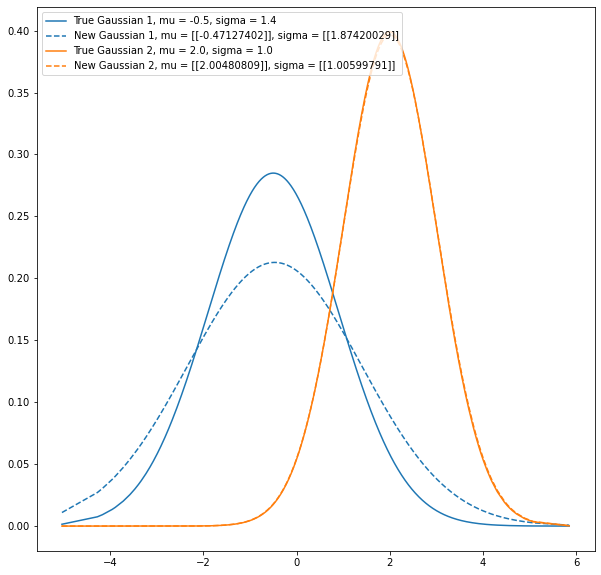

In [289]:
plot_new_gaussians_vs_old(gaussian_1_truth, gaussian_2_truth, new_gaussian_1, new_gaussian_2, all_samples)


    1.D) Starting with two randomly assigned gaussians, can you successfully run the EM steps repeatedly and converge close to your truth?

Let's define two random gaussian as our starting point (Not the true gaussians, as above) and see if we can get close to the truth by taking 1000 maximization steps.

In [290]:
def make_random_gaussians():
    return norm(loc = np.random.uniform(-100,100), scale = np.random.uniform(0.1,100)), norm(loc = np.random.uniform(-100,100), scale = np.random.uniform(0.1,10))

In [291]:
from copy import deepcopy
n_steps = 1000
prior = 0.001

results = {'gaussian_1': [], 'gaussian_2': []}
gaussian_1, gaussian_2 = make_random_gaussians()

results['gaussian_1'].append(deepcopy(gaussian_1))
results['gaussian_2'].append(deepcopy(gaussian_2))
for step in range(n_steps):
    all_samples['expectation_in_1'] = calculate_expectation(gaussian_1_truth, gaussian_2_truth, all_samples, prior = prior).T
    gaussian_1, gaussian_2, prior = maximization_step(all_samples['expectation_in_1'], all_samples['samples'])
    results['gaussian_1'].append(deepcopy(gaussian_1))
    results['gaussian_2'].append(deepcopy(gaussian_2))


Lets try to plot the initial random gaussians and the ground truth

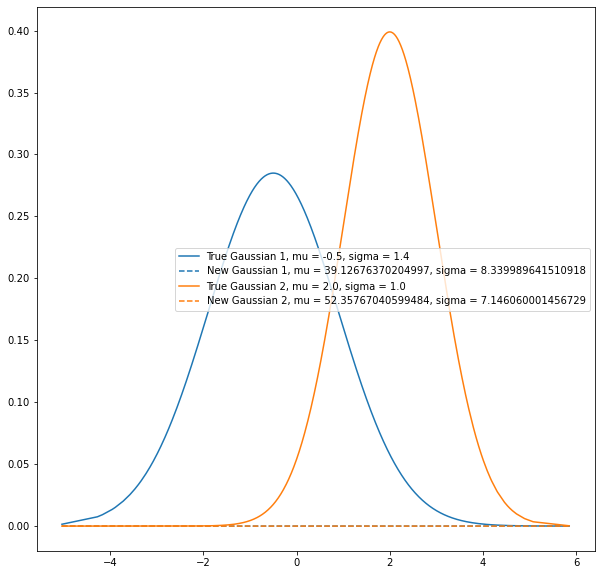

In [292]:
plot_new_gaussians_vs_old(gaussian_1_truth, gaussian_2_truth,  results['gaussian_1'][0],  results['gaussian_2'][0], all_samples)

Let's now try to plot the latest gaussians from the maximization process

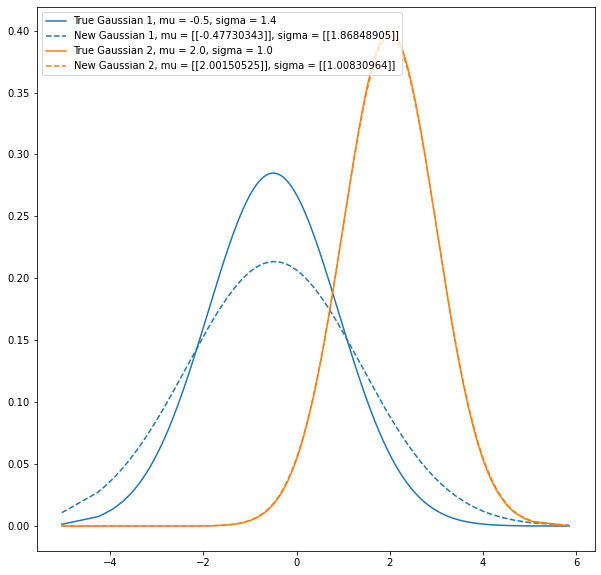

In [293]:
plot_new_gaussians_vs_old(gaussian_1_truth, gaussian_2_truth,  results['gaussian_1'][-1],  results['gaussian_2'][-1], all_samples)

Not perfect, but pretty close!